In [4]:
from IPython.display import display
from ipywidgets import FloatProgress

import sys
sys.path.append('../src')

import neuralnetworkclassifier as nnc
import mlutils as ml
import perturb as per
import dataset_manipulations as dm

import pickle, gzip
import numpy as np
import pandas as pd
import itertools
import copy
import pickle
import glob

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.style.use('seaborn-whitegrid')

In [11]:
import imp
imp.reload(per)
imp.reload(dm)
imp.reload(nnc)

<module 'neuralnetworkclassifier' from '../src/neuralnetworkclassifier.py'>

In [3]:
# !curl -O http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# !tar -xvf cifar-10-python.tar.gz

## Loading Data

The functionality of loading the CIFAR 10 dataset has been extracted to a separate source file, `dataset_manipulations`. This file also offers the functionality of storing a set of CIFAR images again, in the same format that they originally come in. This enables us to augment batches of images and save them in their original form to be loaded in again later.

(50000, 3, 32, 32) (50000, 1) (10000, 3, 32, 32) (10000, 1)


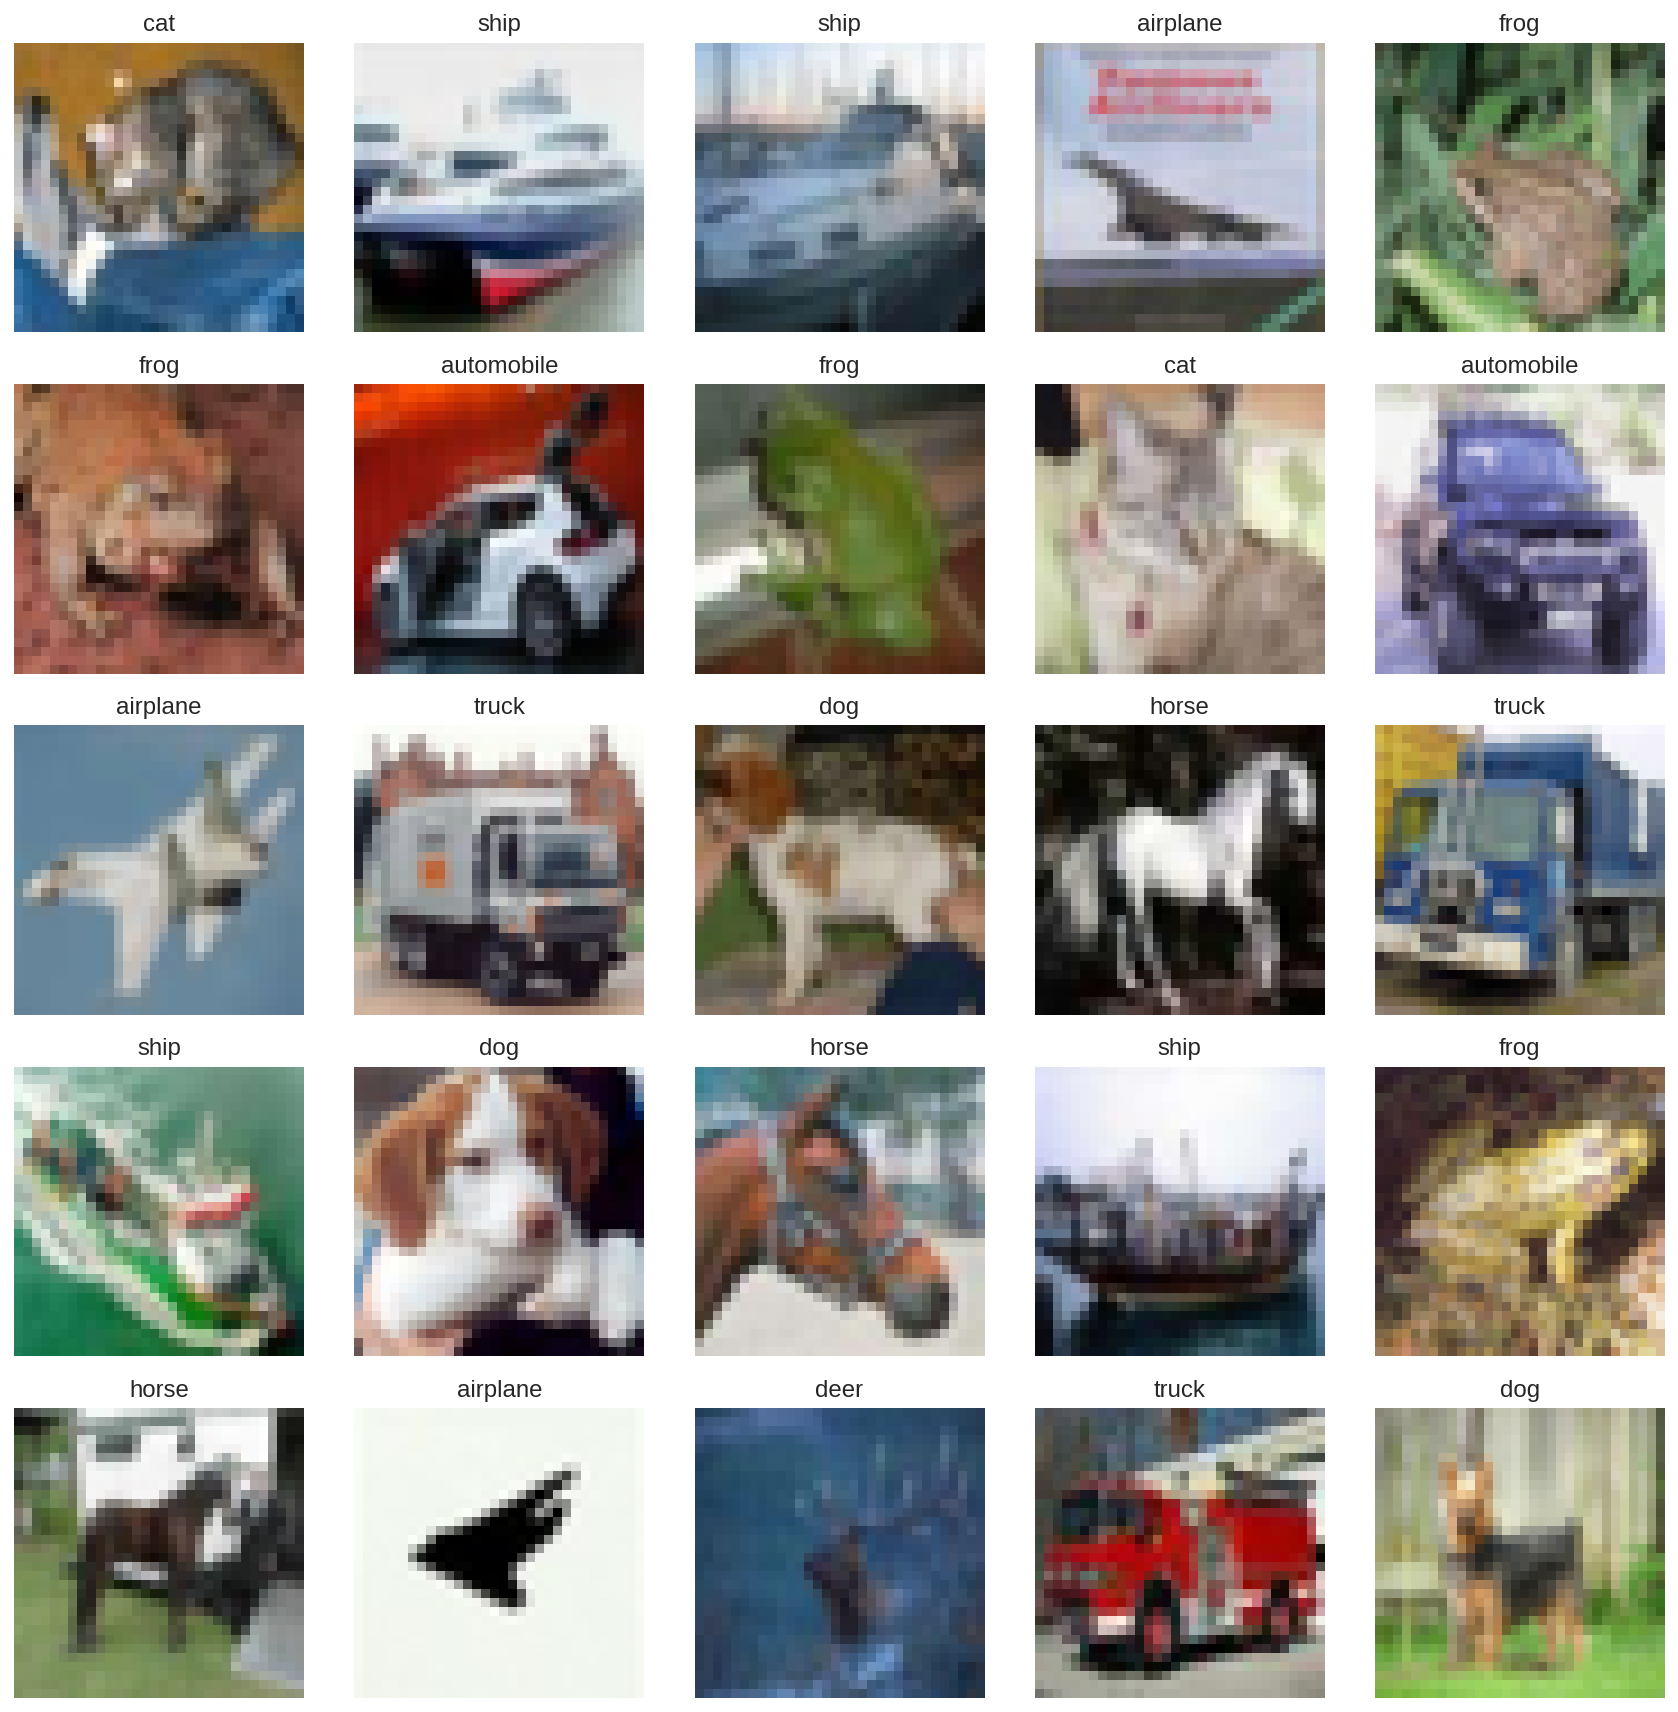

In [4]:
Xtrain, Ttrain = dm.load_cifar_10('./cifar-10-batches-py/data_batch_*')# load('data_batch_*')
Xtest, Ttest, = dm.load_cifar_10('./cifar-10-batches-py/test_batch') # load('test_batch')

print(Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape)
    
with open('cifar-10-batches-py/batches.meta', 'rb') as f:
    class_names = pickle.load(f, encoding='bytes')
class_names = class_names[b'label_names']
classes = np.unique(Ttrain)
    
def imshow(Xset, Tset):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(np.moveaxis(Xset[i,...], 0, 2), interpolation='nearest')
        plt.axis('off')
        unicode = class_names[Tset[i][0]].decode('utf-8')
        plt.title(unicode) 

    plt.tight_layout()
    
imshow(Xtest, Ttest)

## Applying Noise Perturbations

We can simulate image noise with slight changes that are based on a normal distribution. Every pixel is altered by some value from the normal distribution. The variance of the distribution determines how likely that a pixel will drastically change.

We can apply this noise for a single example image with a few lines:

In [ ]:
ex = Xtrain[np.random.randint(len(Xtrain))]
plt.imshow(np.moveaxis(ex, 0, 2), interpolation='nearest')
plt.axis('off')

In [ ]:
noise = np.random.normal(0, 0.05, ex.shape)
ex = ex + noise

In [ ]:
plt.imshow(np.moveaxis(ex, 0, 2), interpolation='nearest')
plt.axis('off')

#### Math Definitions of Noise Augmentation

To simulate extra noise in images, a function was created to additively apply a normal distribution of augmentation values to the image, parameterized by the variance of the distribution. In other words, every pixel in each input image was altered by some value from the normal distribution (with a mean of 0). As the variance (the standard deviation of the distribution) increased, so too did the probability that a pixel would be augmented by a more extreme value.

To illustrate this process formally, we use the normal distribution defined by $\mathcal{N} (0, \sigma^2)$, where the mean of the value change to any pixel is 0, and the variance $\sigma$ is an adjustable parameter that relates directly to the "noisiness" of the resulting image. From this distribution, we sample values between -1 and 1. The higher the variance, the more often any one sample will be closer to -1 or 1. These samples are used to augment the image additively, as all pixels in the image are represented by a value between 0 and 1. The addition of these samples changes the values of every pixel in the image slightly (except for those samples of exactly 0). If any resulting pixel is outside the range between 0 and 1, then the value is clipped accordingly. The end result is an augmented image that has

In this work, we have found that a variance of 0.1 creates images with an unrealistic amount of noise, while a variance of 0.05 results in a more acceptable amount of noise in the images.

## Augmenting the Entire Dataset

We can apply a perturbation technique to the entire dataset using the `dataset_manipulations` module, and then we can save off the resulting images.

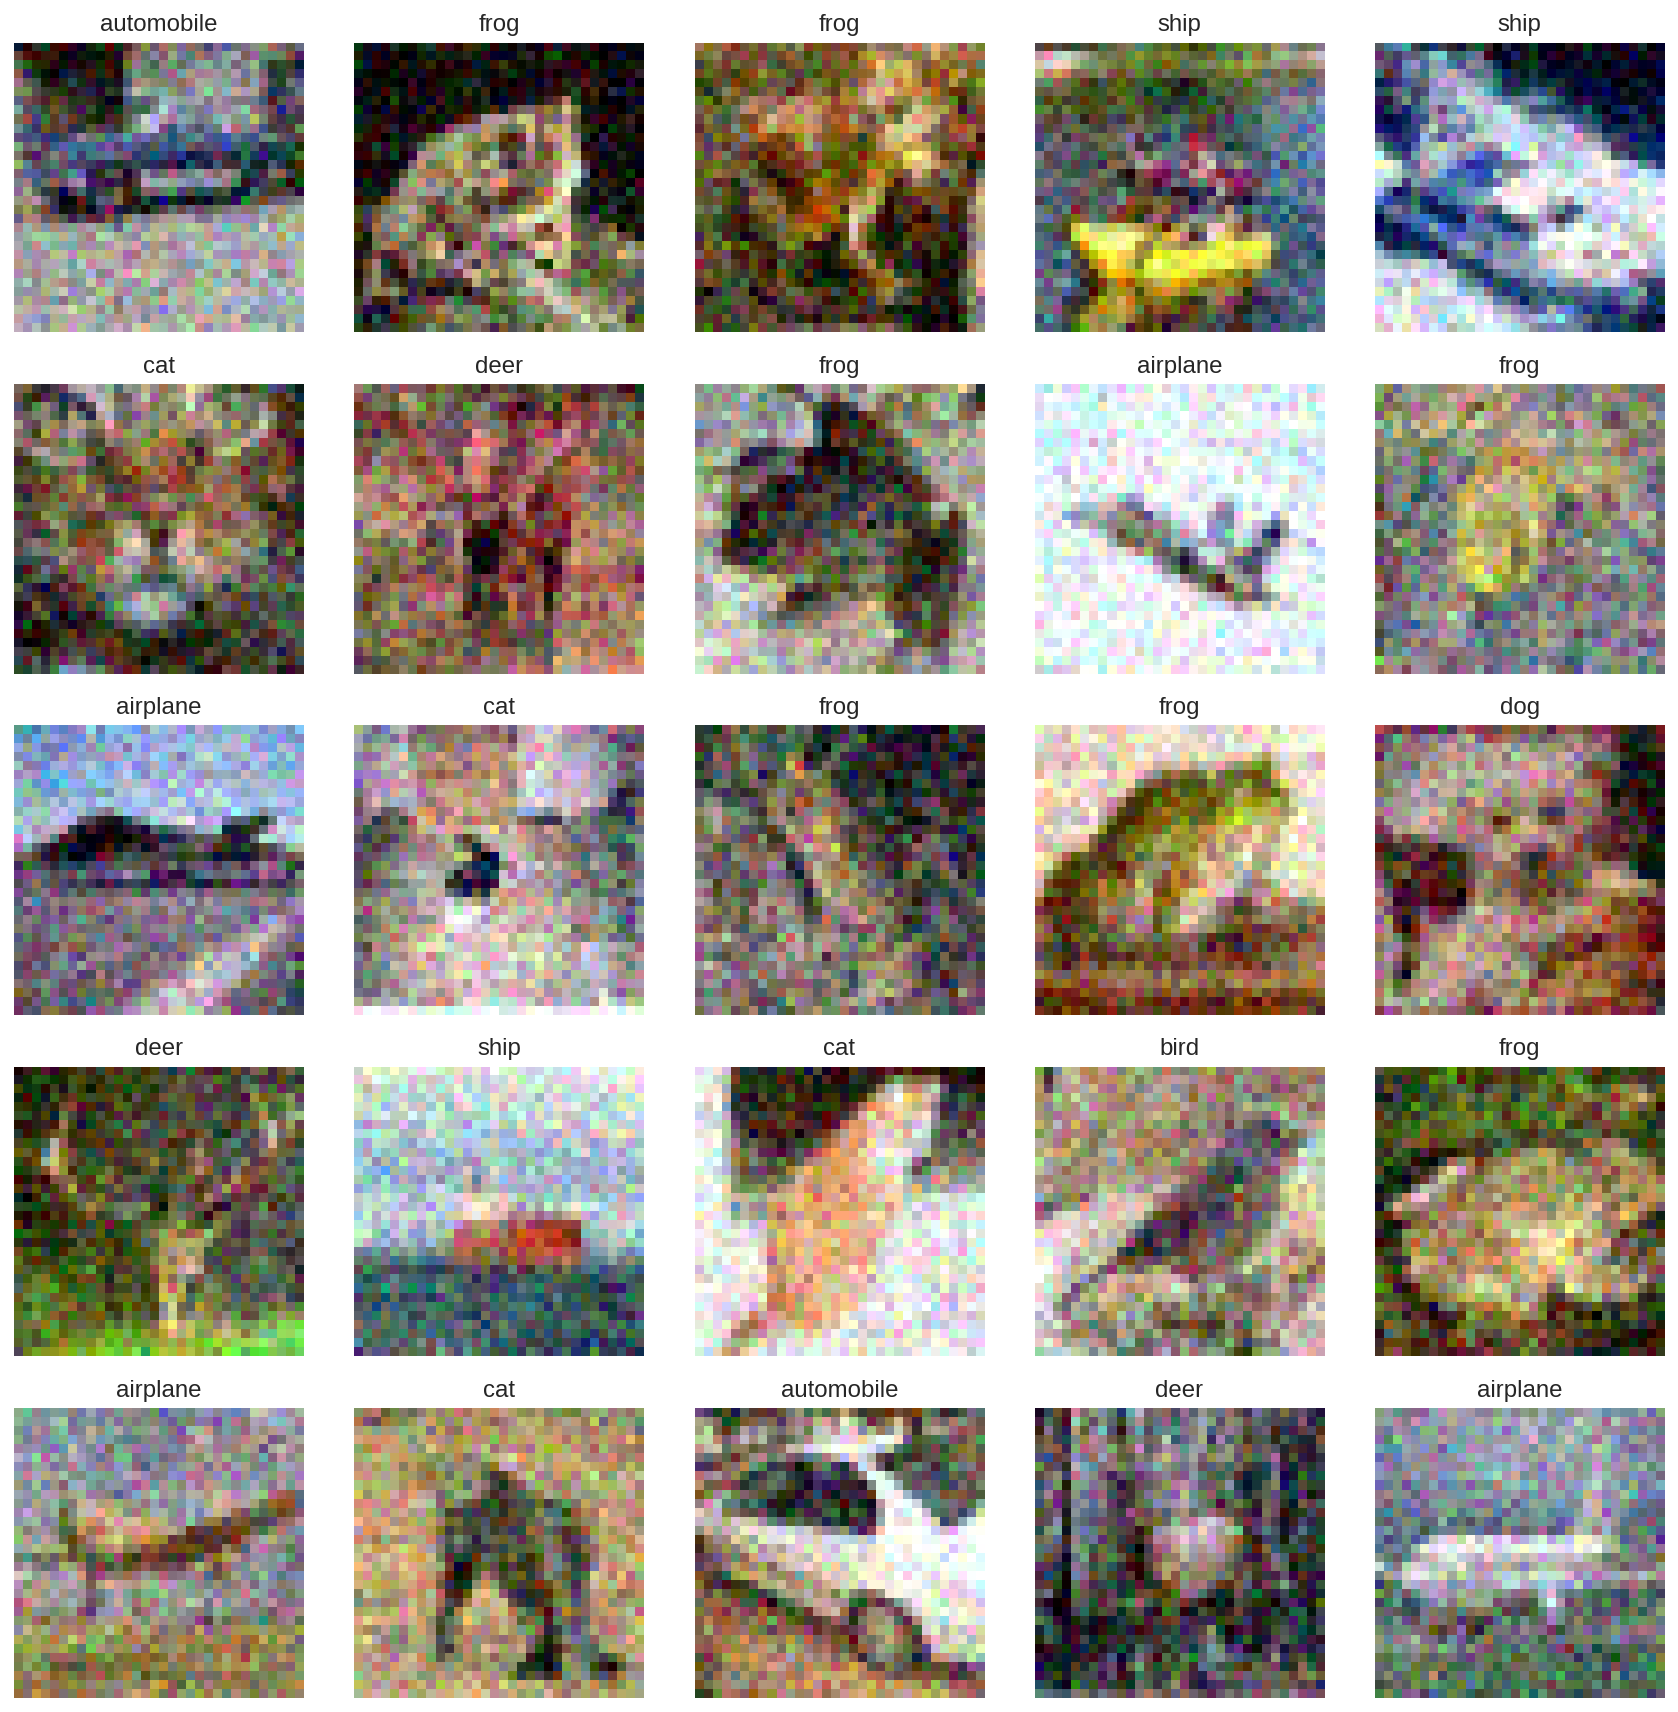

In [5]:
new_Xtrain = dm.apply_manipulations(Xtrain, lambda x: per.add_image_noise(x, variance=0.1))
new_Xtest = dm.apply_manipulations(Xtest, lambda x: per.add_image_noise(x, variance=0.1))
imshow(new_Xtrain, Ttrain)

We can also apply our stuck pixel perturbation across the dataset:

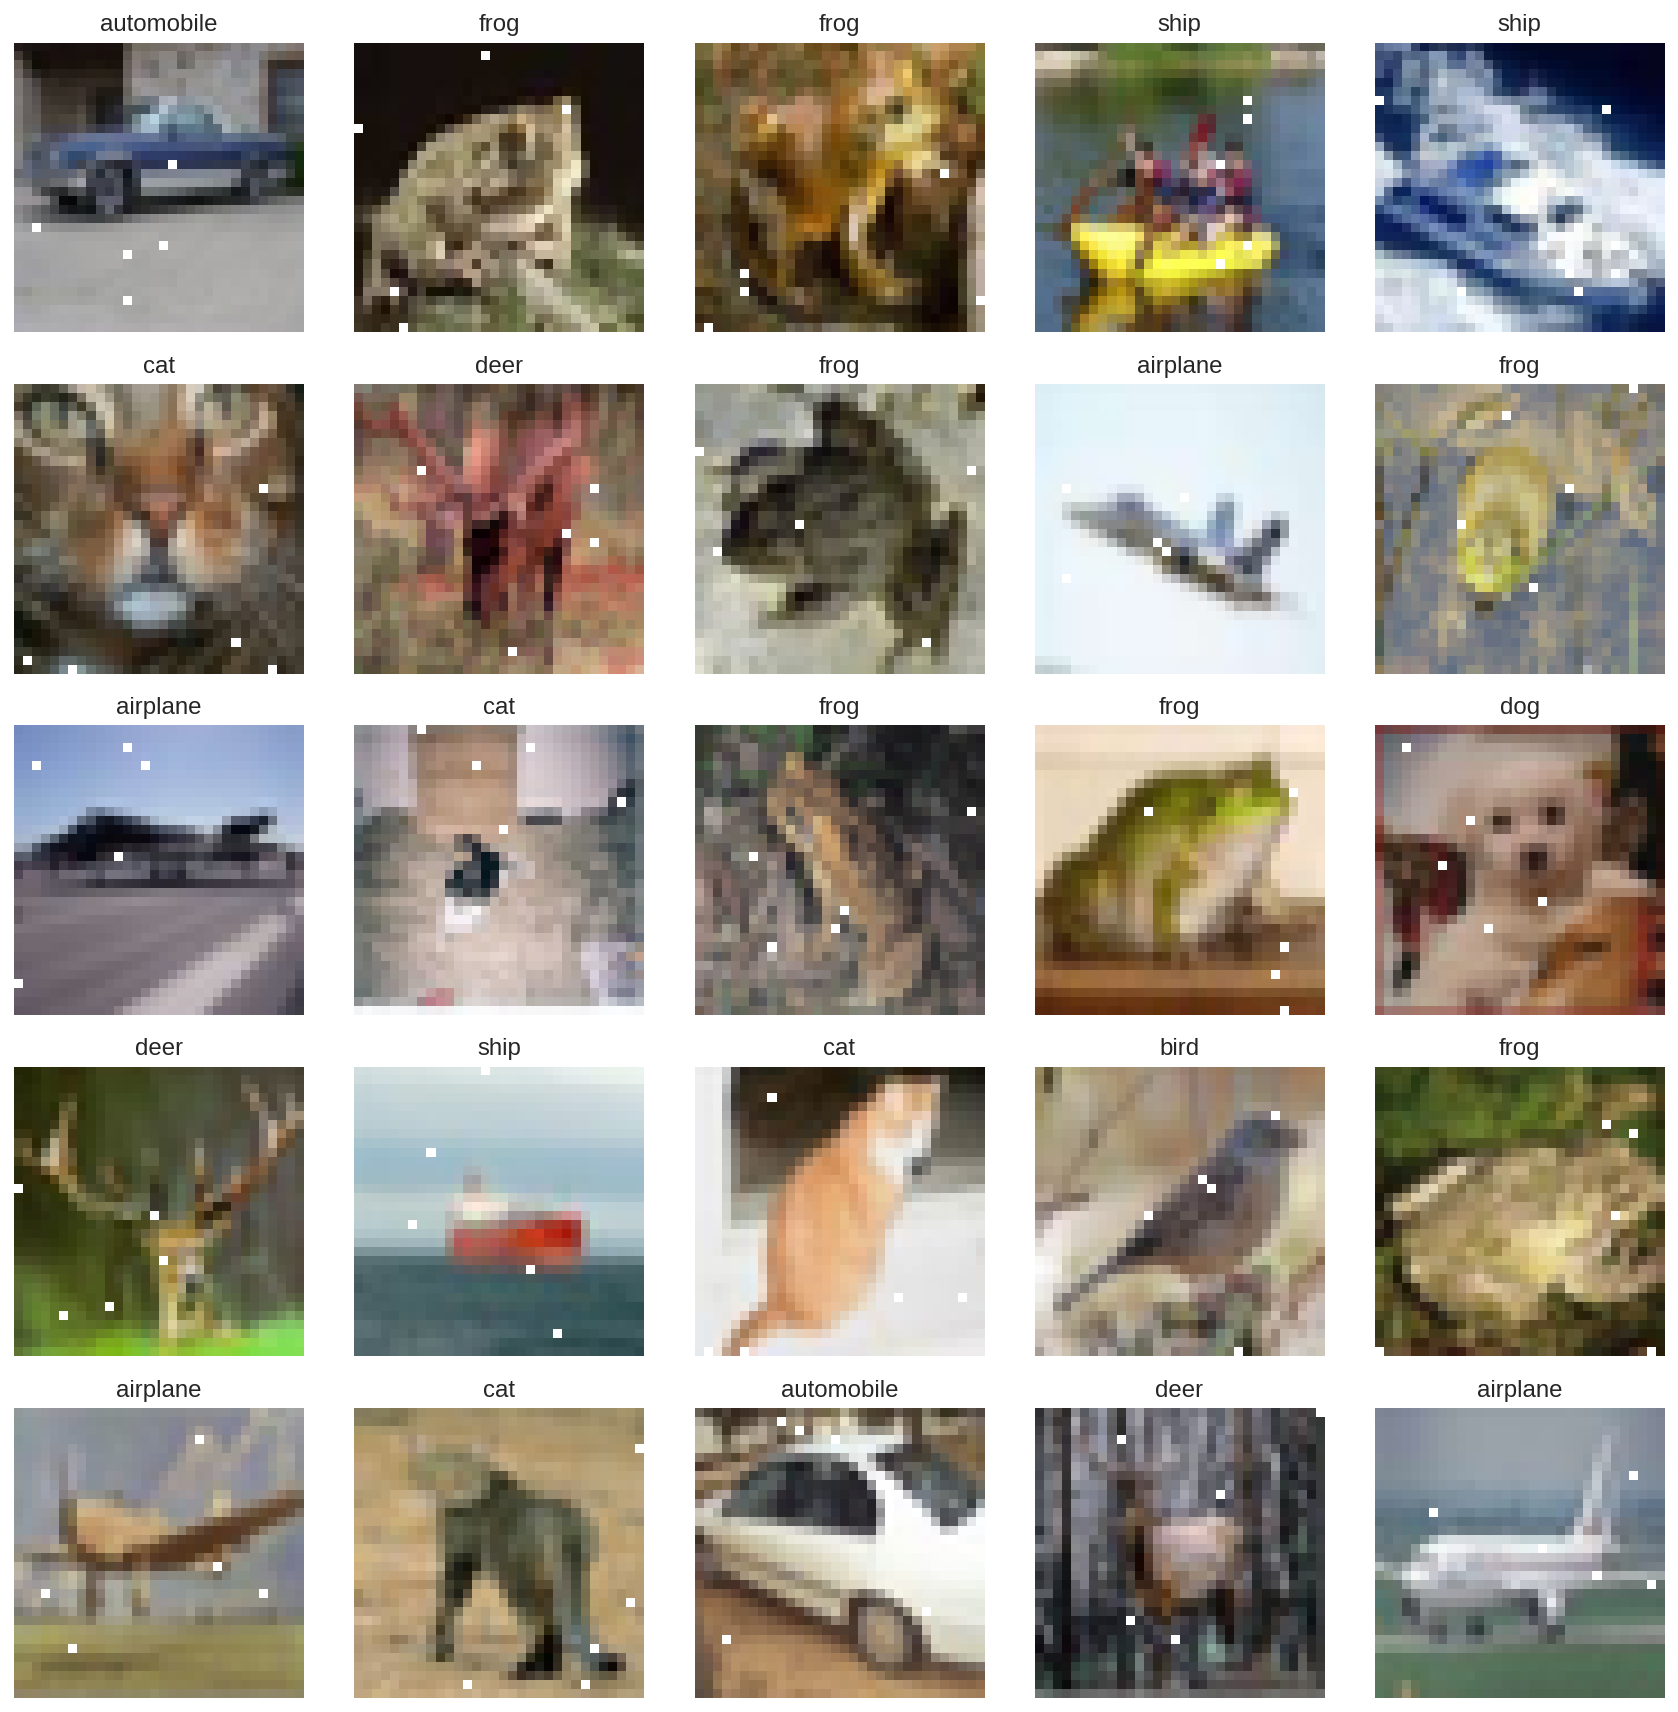

In [11]:
stuck_Xtrain = dm.apply_manipulations(Xtrain, lambda x: per.change_pixel(x, pixels_to_change=5, pertrub='hot'))
stuck_Xtest = dm.apply_manipulations(Xtest, lambda x: per.change_pixel(x, pixels_to_change=5, pertrub='hot'))
imshow(stuck_Xtrain, Ttrain)

We can now save this augmented dataset separately. The resulting file can be loaded again with `dm.load_cifar_10`.

In [ ]:
dm.save_cifar_10('./new-cifar/1var-noise-train', (new_Xtrain, Ttrain))
dm.save_cifar_10('./new-cifar/1var-noise-test', (new_Xtest, Ttest))

#### Applying to MNIST

We can also load and save MNIST data:

In [161]:
Xtrain, Ttrain, Xtest, Ttest, Xvalid, Tvalid = dm.load_mnist('./mnist.pkl.gz')

In [162]:
def imshow_mnist(Xset):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        axs[i].imshow(Xset[np.random.randint(Xset.shape[0])][0])
        axs[i].grid(False)
        axs[i].axis('off')
    plt.show()

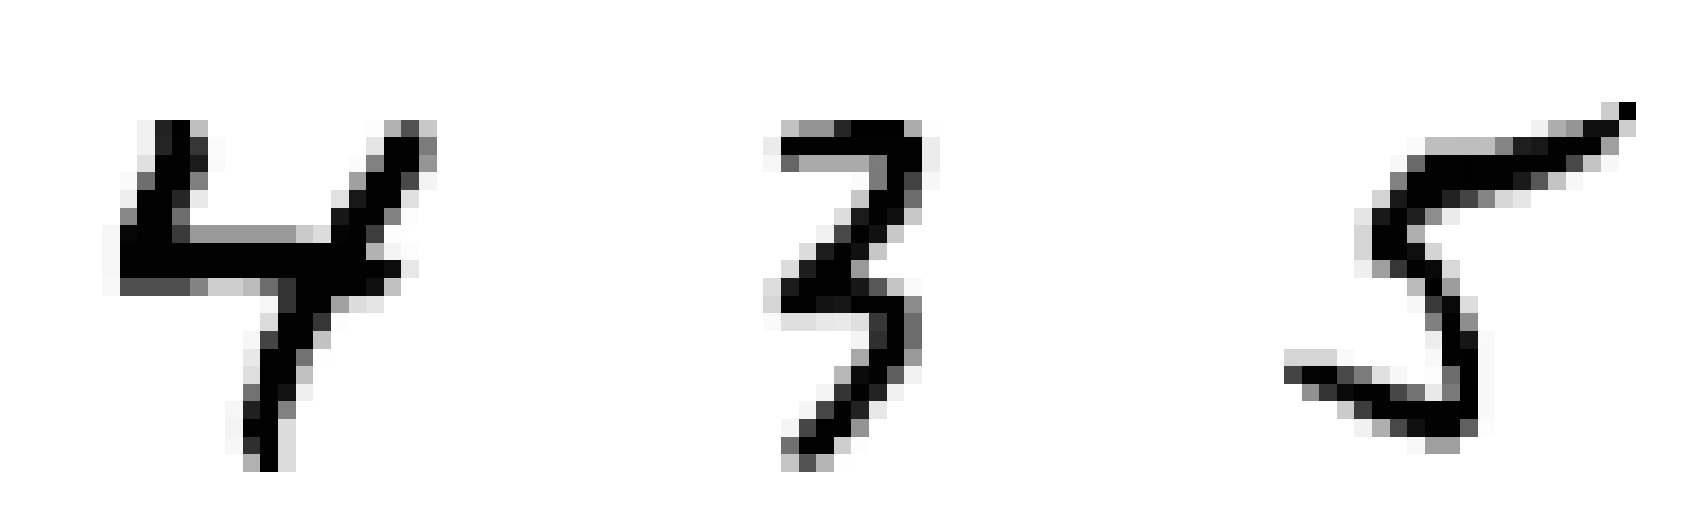

In [163]:
imshow_mnist(Xtrain)

In [164]:
stuck_Xtrain = dm.apply_manipulations(Xtrain, lambda x: per.change_pixel(x, pixels_to_change=5, pertrub='hot'))

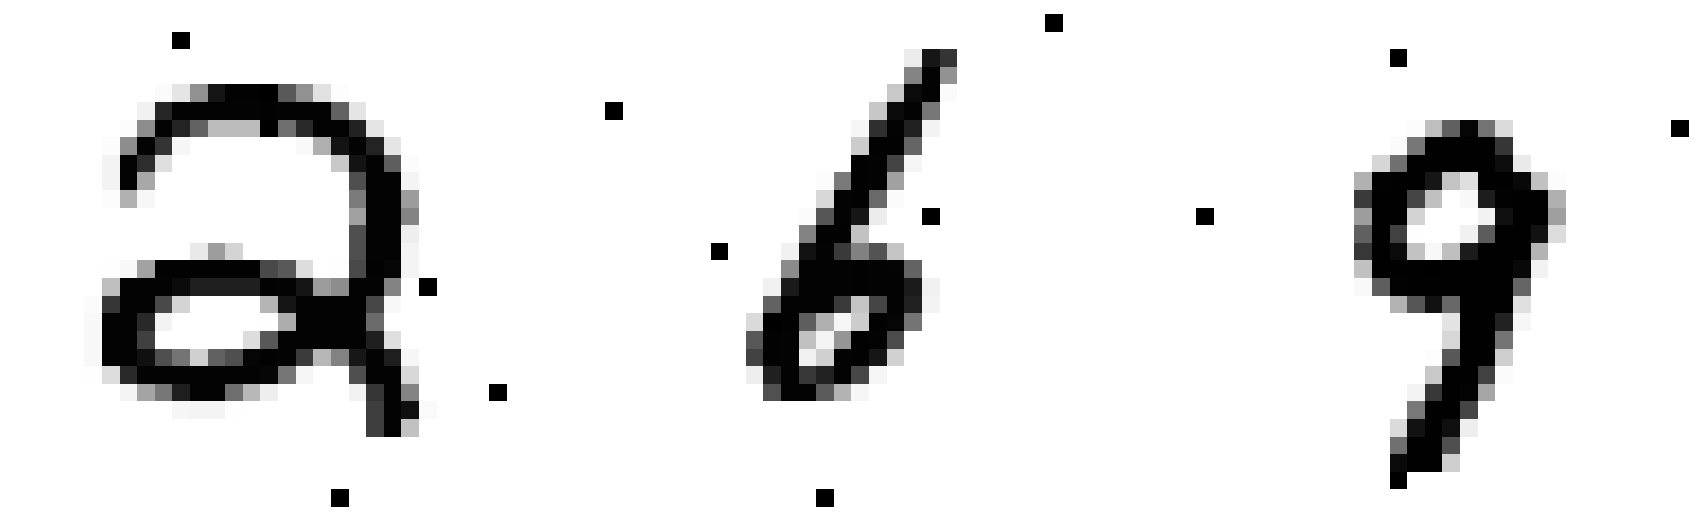

In [165]:
imshow_mnist(stuck_Xtrain)

We can save MNIST data as well:

In [166]:
dm.save_mnist((stuck_Xtrain, Ttrain), (Xtest, Ttest), (Xvalid, Tvalid), './stuck_mnist.pkl.gz')

In [167]:
other, _, _, _, _, _ = dm.load_mnist('./stuck_mnist.pkl.gz')

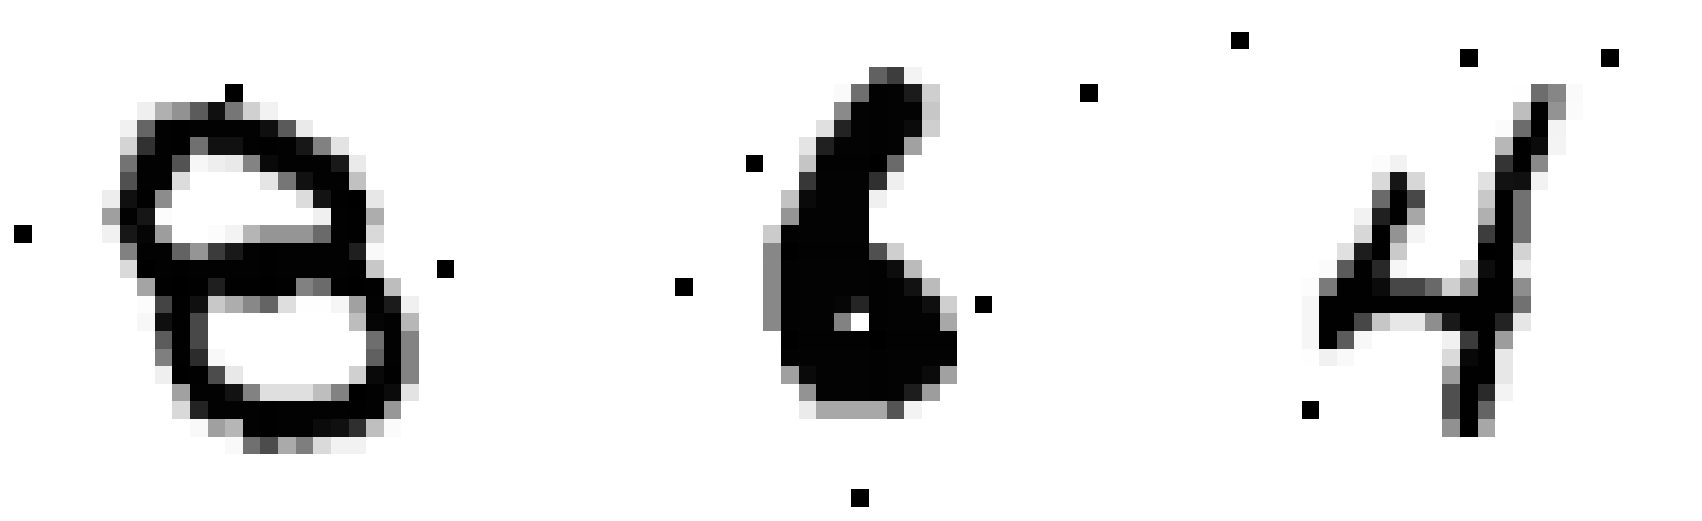

In [168]:
imshow_mnist(other)

## Evaluating the Detrimental Effects of Simulated Noise

In this section, we evaluated the performance of a network trained on clean images on classifying images augmented with different variations of noise.

In [ ]:
nnet = nnc.NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[25, 25, 25],
                                   kernels_size_and_stride=[(4, 2), (5, 2), (2, 1)],
                                   n_units_in_fc_hidden_layers=[],
                                   classes=classes,
                                   use_gpu=True)
rho = 0.001
epochs = 2000
nnet.train(Xtrain, Ttrain, epochs, learning_rate=rho, verbose=True)

In [ ]:
classes, Y    = nnet.use(Xtrain)
train_percent = ml.percent_correct(Ttrain, classes)
classes, Y    = nnet.use(Xtest)
test_percent  = ml.percent_correct(Ttest, classes)
print(f'Train Percentage: {train_percent}, Test Percentage: {test_percent}')

In [ ]:
_ = ml.confusion_matrix(Ttest, classes, np.unique(Ttest))

In [ ]:
noise_variance = 0.1
Xcopy = per.add_image_noise(Xtest, noise_variance)
diff_index, percent_diff = per.classified_diff(nnet, Xtest, Xcopy, Ttest)
print(f'''Total of {len(diff_index)} misclassified samples,
      with a {percent_diff:.3f}% difference from test by adding noise with {noise_variance}''')
per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='CIFAR',
           name='media/cifar_example_1var_noise.pdf')
print(class_names)

In [ ]:
index = 1675
augmented = []
for i in np.linspace(0.005, 0.2, 14):
    augmented.append(per.add_image_noise(Xtest[index], i))
augmented = np.array(augmented)

In [ ]:
plt.figure(figsize=(9, 4))

Xset_class, _ = nnet.use(Xtest[index:index+1])
print()
for i in range(14):
    plt.subplot(2, 7, i + 1)
    plt.imshow(np.moveaxis(augmented[i, ...], 0, 2), interpolation='nearest')
    
    Xcopy_class, _ = nnet.use(augmented[i:i+1])
    plt.title('$X_i$: {0}, $M_i$: {1},\n$T_i$: {2}'.format(Xset_class[0][0],
                                                           Xcopy_class[0][0],
                                                           Ttest[index][0]))
    plt.axis('off')
plt.tight_layout();
plt.savefig('./media/gradient_noise.pdf', bbox_inches='tight')
plt.show();

In [ ]:
noise_variance = 0.01
# Xcopy = per.add_image_noise(Xtest, noise_variance)
diff_index, percent_diff = per.classified_diff(nnet, Xtest, Xcopy, Ttest)
print(f'''Total of {len(diff_index)} misclassified samples,
      with a {percent_diff:.3f}% difference from test by adding noise with {noise_variance}''')
per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='CIFAR',
           name='media/cifar_example_1var_noise.pdf')
print(class_names)

In [ ]:
x, y, yerr = per.test_increasing_noise(nnet, Xtest, Ttest, (0.005, 0.1), 5, 25)

In [ ]:
(x, y, yerr)

In [ ]:
plt.figure(figsize=(6, 4))

plt.errorbar(x, y, yerr=yerr, marker='.',
             lw=1, capsize=5, capthick=1.5, markeredgecolor='k')

plt.xlabel('Variance of Added Noise')
plt.ylabel('Mean \% Misclassified')
plt.xticks(x)
plt.grid(True); plt.tight_layout()
plt.savefig('media/noise_variance_linear.pdf', bbox_inches='tight')
plt.show()